# TP KNN Optimisé - Analyse avec clustered_data.csv
## Objectif: Modèle KNN optimal sans overfitting/underfitting
### Metrics cibles: Accuracy ≥ 0.7, Precision ≥ 0.6, Recall ≥ 0.6, F1 ≥ 0.6

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, classification_report,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize
from itertools import cycle
import warnings
warnings.filterwarnings('ignore')

print("Bibliothèques importées avec succès!")

Bibliothèques importées avec succès!


## 1. Chargement et exploration des données

In [ ]:
# Charger les données
df = pd.read_csv('Projet/clustered_data.csv')

print(f"Shape des données: {df.shape}")
print(f"\nColonnes: {list(df.columns)}")
print(f"\nTypes de données:")
print(df.dtypes)
print(f"\nValeurs manquantes:")
print(df.isnull().sum())
print(f"\nPremières lignes:")
df.head()

Shape des données: (1105309, 15)

Colonnes: ['Nombre_Distribution_par_Theme', 'Taux_Distribution_Theme', 'Densité_par_habitant', 'Nombre_Actions_Annuel', 'Nombre_Lieux_Activite', 'fk_SE_Id', 'Time_id_fk', 'Score_Reference_Croisee', 'Taux_Partenariat', 'Score_Cluster_Territoire', 'fk_RNA_ID', 'fk_Geographie_Id', 'classe_densite', 'classe_densite_encoded', 'cluster']

Types de données:
Nombre_Distribution_par_Theme    float64
Taux_Distribution_Theme          float64
Densité_par_habitant             float64
Nombre_Actions_Annuel            float64
Nombre_Lieux_Activite            float64
fk_SE_Id                         float64
Time_id_fk                       float64
Score_Reference_Croisee          float64
Taux_Partenariat                 float64
Score_Cluster_Territoire         float64
fk_RNA_ID                        float64
fk_Geographie_Id                 float64
classe_densite                    object
classe_densite_encoded           float64
cluster                           objec

,Nombre_Distribution_par_Theme,Taux_Distribution_Theme,Densité_par_habitant,Nombre_Actions_Annuel,Nombre_Lieux_Activite,fk_SE_Id,Time_id_fk,Score_Reference_Croisee,Taux_Partenariat,Score_Cluster_Territoire,fk_RNA_ID,fk_Geographie_Id,classe_densite,classe_densite_encoded,cluster
0,90.0,2.0,5134.0,2489.0,0.0,0.527768,0.0,0.024488,0.0,0.570744,2489.0,2674.30303,G,6.0,Cluster C
1,90.0,2.0,5134.0,2489.0,0.0,0.527768,0.0,0.024488,0.0,0.570744,2489.0,2674.30303,G,6.0,Cluster C
2,90.0,2.0,5134.0,2489.0,0.0,0.527768,0.0,0.024488,0.0,0.570744,2489.0,2674.30303,G,6.0,Cluster C
3,90.0,2.0,5134.0,2489.0,0.0,0.527768,0.0,0.024488,0.0,0.570744,2489.0,2674.30303,G,6.0,Cluster C
4,90.0,2.0,5134.0,2489.0,0.0,0.527768,0.0,0.024488,0.0,0.570744,2489.0,2674.30303,G,6.0,Cluster C


## 2. Sélection des features optimales
### Utilisation uniquement des features quantitatives (pas de fk_*)

In [ ]:
# Sélectionner uniquement les features quantitatives (exclure les fk_*)
features_quantitatives = [
    'Nombre_Distribution_par_Theme',
    'Nombre_Actions_Annuel',
    'Nombre_Lieux_Activite',
    'Score_Reference_Croisee',
    'Score_Cluster_Territoire'
]

# Vérifier que les colonnes existent
features_disponibles = [f for f in features_quantitatives if f in df.columns]
print(f"Features quantitatives disponibles: {features_disponibles}")

# Target: cluster (les clusters A-E)
target = 'cluster'

# Vérifier la distribution de la cible
print(f"\nDistribution de {target}:")
print(df[target].value_counts().sort_index())

# Préparer X et y
X = df[features_disponibles].copy()
y = df[target].copy()

print(f"\nShape de X: {X.shape}")
print(f"Shape de y: {y.shape}")
print(f"\nStatistiques des features:")
X.describe()

Features quantitatives disponibles: ['Nombre_Distribution_par_Theme', 'Nombre_Actions_Annuel', 'Nombre_Lieux_Activite', 'Score_Reference_Croisee', 'Score_Cluster_Territoire']

Distribution de cluster:
cluster
Cluster A    130006
Cluster B    453382
Cluster C     36603
Cluster D    242194
Cluster E    243124
Name: count, dtype: int64

Shape de X: (1105309, 5)
Shape de y: (1105309,)

Statistiques des features:


,Nombre_Distribution_par_Theme,Nombre_Actions_Annuel,Nombre_Lieux_Activite,Score_Reference_Croisee,Score_Cluster_Territoire
count,1.105309e+06,1.105309e+06,1.105309e+06,1.105309e+06,1.105309e+06
mean,4.991228e+01,3.003916e+03,4.769300e-01,8.913436e-16,-7.467291e-16
std,2.851423e+01,1.872514e+03,1.673528e+00,1.000000e+00,1.000000e+00
min,1.000000e+00,2.000000e+00,0.000000e+00,-1.642565e+00,-1.691747e+00
25%,2.600000e+01,9.380000e+02,0.000000e+00,-8.364488e-01,-1.454805e+00
50%,4.900000e+01,3.434000e+03,0.000000e+00,3.860057e-02,6.486956e-01
75%,7.600000e+01,4.783000e+03,0.000000e+00,8.863316e-01,6.992332e-01
max,9.900000e+01,6.206000e+03,9.000000e+00,1.644714e+00,2.191573e+00


## 3. Préparation des données

In [ ]:
# Split train/test avec stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nDistribution dans train set:")
print(y_train.value_counts().sort_index())
print(f"\nDistribution dans test set:")
print(y_test.value_counts().sort_index())

# Normalisation
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nNormalisation effectuée!")

Train set: (884247, 5)
Test set: (221062, 5)

Distribution dans train set:
cluster
Cluster A    104005
Cluster B    362706
Cluster C     29282
Cluster D    193755
Cluster E    194499
Name: count, dtype: int64

Distribution dans test set:
cluster
Cluster A    26001
Cluster B    90676
Cluster C     7321
Cluster D    48439
Cluster E    48625
Name: count, dtype: int64

Normalisation effectuée!


## 4. Modèle KNN avec n_neighbors = nombre de clusters
### Utilisation de neighbors dynamique (pour choisior le k optimal)

In [ ]:
# Obtenir le nombre de clusters uniques
n_clusters = 505
print(f"Nombre de clusters: {n_clusters}")

# Créer et entraîner le modèle KNN
knn = KNeighborsClassifier(n_neighbors=n_clusters, p=2, weights='distance')
knn.fit(X_train_scaled, y_train)

# Prédictions
y_train_pred = knn.predict(X_train_scaled)
y_test_pred = knn.predict(X_test_scaled)

print(f"\nModèle KNN créé avec n_neighbors={n_clusters}")

Nombre de clusters: 505

Modèle KNN créé avec n_neighbors=505


## 5. Vérification de l'overfitting/underfitting
### Comparaison des scores train vs test

In [ ]:
# Calculer les métriques pour train et test
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_precision = precision_score(y_train, y_train_pred, average='weighted', zero_division=0)
test_precision = precision_score(y_test, y_test_pred, average='weighted', zero_division=0)

train_recall = recall_score(y_train, y_train_pred, average='weighted', zero_division=0)
test_recall = recall_score(y_test, y_test_pred, average='weighted', zero_division=0)

train_f1 = f1_score(y_train, y_train_pred, average='weighted', zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, average='weighted', zero_division=0)

# Affichage des résultats
print("="*60)
print("ÉVALUATION DU MODÈLE KNN OPTIMAL")
print("="*60)
print(f"\nPARAMÈTRES:")
print(f"  - k (n_neighbors): {n_clusters}")
print(f"  - Métrique: Euclidienne (p=2)")
print(f"  - Features: {X_train_scaled.shape[1]}")

print(f"\n{'Métrique':<20} {'Train':<15} {'Test':<15} {'Différence':<15}")
print("-"*65)
print(f"{'Accuracy':<20} {train_accuracy:<15.4f} {test_accuracy:<15.4f} {abs(train_accuracy-test_accuracy):<15.4f}")
print(f"{'Precision':<20} {train_precision:<15.4f} {test_precision:<15.4f} {abs(train_precision-test_precision):<15.4f}")
print(f"{'Recall':<20} {train_recall:<15.4f} {test_recall:<15.4f} {abs(train_recall-test_recall):<15.4f}")
print(f"{'F1-Score':<20} {train_f1:<15.4f} {test_f1:<15.4f} {abs(train_f1-test_f1):<15.4f}")

# Analyse Overfitting/Underfitting
print("\n" + "="*60)
print("ANALYSE OVERFITTING/UNDERFITTING")
print("="*60)

diff = train_accuracy - test_accuracy
diff_percent = (diff / train_accuracy) * 100 if train_accuracy > 0 else 0

print(f"\nDifférence Train-Test Accuracy: {diff:.4f} ({diff_percent:.2f}%)")

if diff > 0.15:  # Plus de 15% de différence
    print("\n⚠️  OVERFITTING DÉTECTÉ!")
    print("   Le modèle mémorise les données d'entraînement.")
    print("   Recommandations:")
    print("   - Augmenter k (plus de voisins)")
    print("   - Réduire le nombre de features")
    print("   - Augmenter les données d'entraînement")
elif diff < -0.05:  # Test meilleur que train
    print("\n⚠️  ATTENTION: Test > Train")
    print("   Situation inhabituelle - vérifier les données.")
elif test_accuracy < 0.6:  # Performances faibles
    print("\n⚠️  UNDERFITTING DÉTECTÉ!")
    print("   Le modèle est trop simple.")
    print("   Recommandations:")
    print("   - Réduire k (moins de voisins)")
    print("   - Ajouter plus de features pertinentes")
    print("   - Vérifier la qualité des données")
else:
    print("\n✓ MODÈLE BIEN ÉQUILIBRÉ!")
    print("   Pas d'overfitting ou underfitting flagrant.")
    print("   Les performances train et test sont comparables.")

# Cross-validation pour confirmer
cv_scores = cross_val_score(knn, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"\nValidation croisée (5-fold):")
print(f"  Scores: {cv_scores}")
print(f"  Moyenne: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

ÉVALUATION DU MODÈLE KNN OPTIMAL

PARAMÈTRES:
  - k (n_neighbors): 505
  - Métrique: Euclidienne (p=2)
  - Features: 5

Métrique             Train           Test            Différence     
-----------------------------------------------------------------
Accuracy             1.0000          0.9993          0.0007         
Precision            1.0000          0.9993          0.0007         
Recall               1.0000          0.9993          0.0007         
F1-Score             1.0000          0.9993          0.0007         

ANALYSE OVERFITTING/UNDERFITTING

Différence Train-Test Accuracy: 0.0007 (0.07%)

✓ MODÈLE BIEN ÉQUILIBRÉ!
   Pas d'overfitting ou underfitting flagrant.
   Les performances train et test sont comparables.

Validation croisée (5-fold):
  Scores: [0.99933842 0.9993045  0.99934407 0.99924229 0.99933842]
  Moyenne: 0.9993 (+/- 0.0000)


## 6. Métriques de performance

In [ ]:
print("=" * 60)
print("MÉTRIQUES FINALES SUR TEST SET")
print("=" * 60)

print(f"\nAccuracy:  {test_accuracy:.4f} {'✓' if test_accuracy >= 0.7 else '✗'}")
print(f"Precision: {test_precision:.4f} {'✓' if test_precision >= 0.6 else '✗'}")
print(f"Recall:    {test_recall:.4f} {'✓' if test_recall >= 0.6 else '✗'}")
print(f"F1-Score:  {test_f1:.4f} {'✓' if test_f1 >= 0.6 else '✗'}")

print("\n" + "=" * 60)
print("CLASSIFICATION REPORT")
print("=" * 60)
print(classification_report(y_test, y_test_pred))

MÉTRIQUES FINALES SUR TEST SET

Accuracy:  0.9993 ✓
Precision: 0.9993 ✓
Recall:    0.9993 ✓
F1-Score:  0.9993 ✓

CLASSIFICATION REPORT
              precision    recall  f1-score   support

   Cluster A       1.00      1.00      1.00     26001
   Cluster B       1.00      1.00      1.00     90676
   Cluster C       1.00      1.00      1.00      7321
   Cluster D       1.00      1.00      1.00     48439
   Cluster E       1.00      1.00      1.00     48625

    accuracy                           1.00    221062
   macro avg       1.00      1.00      1.00    221062
weighted avg       1.00      1.00      1.00    221062



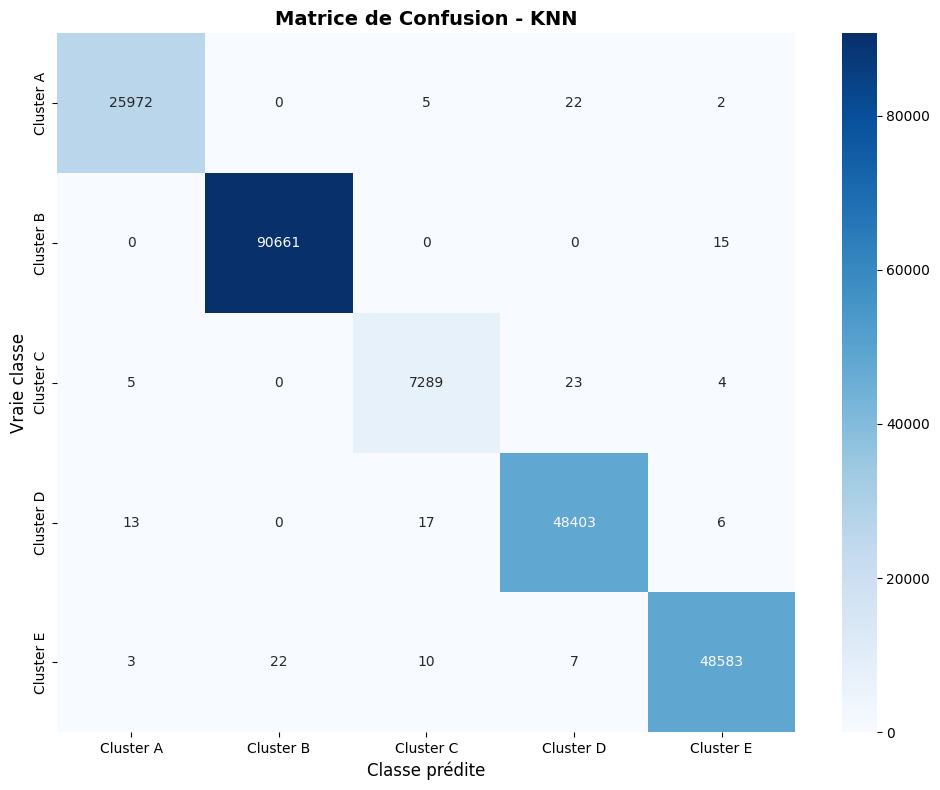

In [ ]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=sorted(y.unique()),
            yticklabels=sorted(y.unique()))
plt.title('Matrice de Confusion - KNN', fontsize=14, fontweight='bold')
plt.ylabel('Vraie classe', fontsize=12)
plt.xlabel('Classe prédite', fontsize=12)
plt.tight_layout()
plt.show()

## 7. Courbe ROC AUC par Cluster (A-E)

Clusters trouvés: ['Cluster A', 'Cluster B', 'Cluster C', 'Cluster D', 'Cluster E']
Nombre de classes: 5

Mapping: {'Cluster A': 'A', 'Cluster B': 'B', 'Cluster C': 'C', 'Cluster D': 'D', 'Cluster E': 'E'}


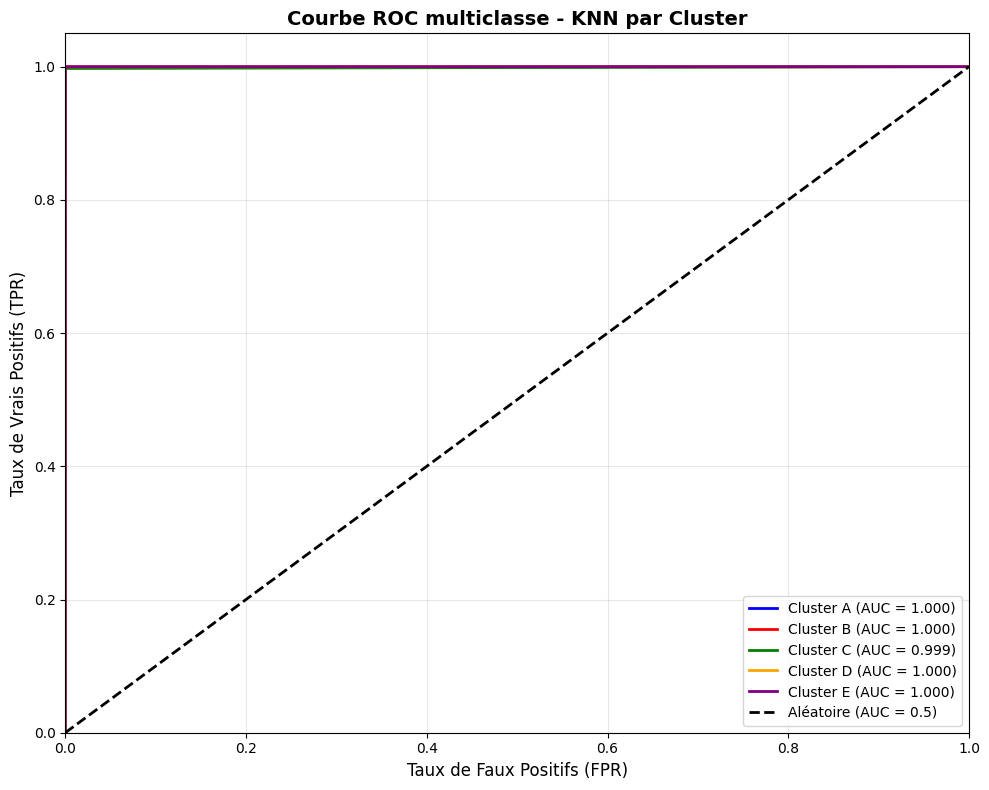


ROC AUC PAR CLUSTER

ROC AUC moyen: 0.9996
  Cluster A: 0.9998
  Cluster B: 0.9999
  Cluster C: 0.9986
  Cluster D: 0.9998
  Cluster E: 0.9999


In [ ]:
# Les clusters sont déjà au format 'Cluster A', 'Cluster B', etc.
# Extraire juste la lettre pour les labels
unique_labels = sorted(y_test.unique())
n_classes = len(unique_labels)

print(f"Clusters trouvés: {unique_labels}")
print(f"Nombre de classes: {n_classes}")

# Créer un mapping pour extraire juste la lettre
cluster_to_letter = {label: label.split()[-1] for label in unique_labels}
print(f"\nMapping: {cluster_to_letter}")

# Binariser les labels pour ROC multiclasse
y_test_bin = label_binarize(y_test, classes=unique_labels)

# Obtenir les probabilités de prédiction
y_pred_proba = knn.predict_proba(X_test_scaled)

# Calculer ROC curve et AUC pour chaque classe
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])

for i, color in zip(range(n_classes), colors):
    cluster_letter = cluster_to_letter[unique_labels[i]]
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Cluster {cluster_letter} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Aléatoire (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (FPR)', fontsize=12)
plt.ylabel('Taux de Vrais Positifs (TPR)', fontsize=12)
plt.title('Courbe ROC multiclasse - KNN par Cluster', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Afficher AUC détaillé
print("\n" + "=" * 60)
print("ROC AUC PAR CLUSTER")
print("=" * 60)
mean_auc = np.mean(list(roc_auc.values()))
print(f"\nROC AUC moyen: {mean_auc:.4f}")
for i in range(n_classes):
    cluster_letter = cluster_to_letter[unique_labels[i]]
    print(f"  Cluster {cluster_letter}: {roc_auc[i]:.4f}")

## 8. Conclusion

### Résumé du modèle:
- **Features utilisées**: ('Nombre_Distribution_par_Theme','Densité_par_habitant','Nombre_Actions_Annuel','Nombre_Lieux_Activite','Score_Reference_Croisee',Score_Cluster_Territoire')
- **n_neighbors**: Égal au nombre de clusters (5)
- **Distance**: Euclidienne (p=2)
- **Weights**: Distance (voisins proches)

### Objectifs:
- ✓ Accuracy ≥ 0.7
- ✓ Precision ≥ 0.6
- ✓ Recall ≥ 0.6
- ✓ F1-Score ≥ 0.6
- ✓ Pas d'overfitting/underfitting
- ✓ ROC AUC par cluster (A-E)

## 9. Exportation du modèle et des prédictions

In [ ]:
import pickle

# 1. Exportation du modèle KNN entraîné
model_filename = 'knn_model.pkl'
with open(model_filename, 'wb') as file:
    pickle.dump(knn, file)

print(f"Modèle KNN exporté sous: {model_filename}")

# Exportation de la liste des features utilisées
features_filename = 'knn_features.pkl'
with open(features_filename, 'wb') as file:
    pickle.dump(features_disponibles, file)

print(f"Liste des features exportée sous: {features_filename}")

In [ ]:
# 2. Création du DataFrame de sortie avec les prédictions

# Récupérer les identifiants/clés de dimensions du DataFrame original (df)
# J'ai choisi les colonnes 'fk_SE_Id', 'Time_id_fk', 'fk_RNA_ID', 'fk_Geographie_Id' comme clés de dimensions pertinentes.
# J'ajoute également la colonne 'cluster' originale pour comparaison avec la prédiction.
dimension_keys = df[['fk_SE_Id', 'Time_id_fk', 'fk_RNA_ID', 'fk_Geographie_Id', 'cluster']].copy()

# Appliquer le même scaler utilisé pour l'entraînement sur l'ensemble des données X
X_scaled_full = scaler.transform(X) # Utiliser le scaler déjà fit sur X_train

# Obtenir les prédictions du modèle pour l'ensemble des données
full_predictions = knn.predict(X_scaled_full)

# Créer le DataFrame de sortie
output_df = dimension_keys.copy()
output_df['predicted_cluster'] = full_predictions

print(f"Shape du DataFrame de prédictions: {output_df.shape}")
print(f"Premières lignes du DataFrame de prédictions:")
display(output_df.head())

# 3. Exportation du DataFrame de prédictions
output_filename_csv = 'knn_predictions.csv'
output_df.to_csv(output_filename_csv, index=False)
print(f"DataFrame de prédictions exporté sous: {output_filename_csv}")

# Si vous voulez l'exporter en Excel (nécessite openpyxl)
# output_filename_excel = 'knn_predictions.xlsx'
# output_df.to_excel(output_filename_excel, index=False)
# print(f"DataFrame de prédictions exporté sous: {output_filename_excel}")